In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import warnings
import matplotlib.colors as colors
import matplotlib.animation as animation
import matplotlib.lines as lines
import datetime
import math
import csv
import random
from seaborn import heatmap
from sociophysicsDataHandler import SociophysicsDataHandler
%matplotlib notebook

In [2]:

dh = SociophysicsDataHandler()
dh.fetch_background_image_from_path('ehv/background_images/EHV.Perron2.1_multisensor.png')

df = pd.read_csv('../simulator/test_results.csv')

#print(df.to_string())

df['tracked_object'] = df['ID']
df.head()



trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/background_images/EHV.Perron2.1_multisensor.png
background fetched. Accessible as <this-object>.bg


,ID,Offboarding,Onboarding,Time,Zone,x_pos,y_pos,tracked_object
0,1000,True,False,1652064199,27,1.0,13,1000
1,1001,False,True,1652064199,27,1.0,13,1001
2,1000,True,False,1652064200,26,1.0,12,1000
3,1001,False,True,1652064200,27,1.0,13,1001
4,1002,True,False,1652064200,13,0.0,13,1002


In [3]:
len(df)

11456

In [4]:
df.tail()

,ID,Offboarding,Onboarding,Time,Zone,x_pos,y_pos,tracked_object
11451,1024,False,True,1652064798,162,11.0,8,1024
11452,1025,False,True,1652064798,748,53.0,6,1025
11453,1026,False,True,1652064798,288,20.0,8,1026
11454,1028,False,True,1652064798,175,12.0,7,1028
11455,1029,False,True,1652064798,35,2.0,7,1029


In [5]:
def checkBounds(df, limits, x_tag = 'x_pos', y_tag = 'y_pos'):
  x_lower = limits[0]
  x_upper = limits[1]
  y_lower = limits[2]
  y_upper = limits[3]

  within_xbounds_series = (df[x_tag] < x_upper) & (df[x_tag] > x_lower)
  within_ybounds_series = (df[y_tag] < y_upper) & (df[y_tag] > y_lower)
  within_bounds_series = within_xbounds_series & within_ybounds_series
  return within_bounds_series

In [6]:
def checkZones(df, zone_names, limits_array):
    for i in range(len(zone_names)):
        df[zone_names[i]] = checkBounds(df, limits_array[i]).astype(float)
    return df

In [7]:
df

,ID,Offboarding,Onboarding,Time,Zone,x_pos,y_pos,tracked_object
0,1000,True,False,1652064199,27,1.0,13,1000
1,1001,False,True,1652064199,27,1.0,13,1001
2,1000,True,False,1652064200,26,1.0,12,1000
3,1001,False,True,1652064200,27,1.0,13,1001
4,1002,True,False,1652064200,13,0.0,13,1002
...,...,...,...,...,...,...,...,...
11451,1024,False,True,1652064798,162,11.0,8,1024
11452,1025,False,True,1652064798,748,53.0,6,1025
11453,1026,False,True,1652064798,288,20.0,8,1026
11454,1028,False,True,1652064798,175,12.0,7,1028


In [8]:
zone_height = 1000
zone_width = 1000
o_x = 5000
o_y = -10000
df['x_pos'] = o_x + zone_width * (df['x_pos'] + 1/2) 
df['y_pos'] = o_y + zone_height * (df['y_pos'] + 1/2)
df.head()

,ID,Offboarding,Onboarding,Time,Zone,x_pos,y_pos,tracked_object
0,1000,True,False,1652064199,27,6500.0,3500.0,1000
1,1001,False,True,1652064199,27,6500.0,3500.0,1001
2,1000,True,False,1652064200,26,6500.0,2500.0,1000
3,1001,False,True,1652064200,27,6500.0,3500.0,1001
4,1002,True,False,1652064200,13,5500.0,3500.0,1002


In [9]:

df_onboarding = df[~(df['Offboarding'] == True)]
df_offboarding = df[~(df['Onboarding'] == True)]

In [10]:
#Function to generate a dataframe with the number of people leaving and entering each zone
def calculate_flux(dataframe, sampling_period):
    
    #Initiate flux dictionaries
    entered_set = {}
    left_set = {}

    t_i = dataframe['Time'].iloc[0]
    t_i = math.floor(t_i/sampling_period) * sampling_period #Round the time to the nearest sampling period multiple
    t_f = dataframe['Time'].iloc[len(dataframe)-1]
    t_f = math.floor(t_f/sampling_period) * sampling_period #Round the time to the nearest sampling period multiple

    # Loop through every second in considered dataframe
    for t in range(t_i, t_f+1, sampling_period):
        entered_set[t] = {}
        left_set[t] = {}
        #Loop through every zone and set the default value to zero
        for zone_name in zone_names:
            entered_set[t][zone_name] = 0
            left_set[t][zone_name] = 0
    
    #Loop through all the IDs in the dataframe
    df_grouped_by_id = dataframe.groupby('tracked_object')
    for index, df_id in df_grouped_by_id:
        #Shift and overlay the boolean values for the zone to detect when a person switches zone   
        #If there is a difference between the previous zone (shifted value) and current zone, a person has changed zone
        df_shifted = df_id[zone_names].shift(periods = -1)
        df_overlay = (df_id[zone_names] != df_shifted)

        #If the shifted and non shifted dataframe don't match, two values will differ (zone left and zone entered)
        #Thus the sum of that specific row will be 2, because True values are returned for differences (!= is used)
        df_id['changed'] = df_overlay.sum(axis=1) == 2
        df_left = df_id[df_id['changed']]
        df_entered = df_id[df_id['changed'].shift(periods= 1) | False]

        #Extract the information from the zone transitions and put them in the dictionary left_set and entered_set  
        zones_left = df_left[zone_names].idxmax(axis = 1)
        for i in range(zones_left.size):
            time = df_left['Time'].iloc[i]
            time = math.floor(time/sampling_period)*sampling_period #Round the time to the nearest sampling period multiple
            left_set[time][zones_left.iloc[i]] -= 1

        zones_entered = df_entered[zone_names].idxmax(axis = 1)
        for i in range(zones_entered.size):
            time = df_entered['Time'].iloc[i]
            time = math.floor(time/sampling_period)*sampling_period #Round the time to the nearest sampling period multiple
            entered_set[time][zones_entered.iloc[i]] += 1

    #Convert the dictionary of people that left or entered a zone to a dataframe
    df_entered_set = pd.DataFrame.from_dict(entered_set)
    df_entered = df_entered_set.transpose()
    df_left_set = pd.DataFrame.from_dict(left_set)
    df_left = df_left_set.transpose()

    #Changing the index from datetime to time in seconds from start
    time = list(range(0,len(df_entered)*sampling_period, sampling_period))
    df_time = pd.DataFrame (time, columns = ['time(s)'])

    df_entered = df_entered.reset_index()
    df_entered = df_entered.drop("index", axis=1)
    df_left = df_left.reset_index()
    df_left = df_left.drop("index", axis=1)
    

    df_entered = pd.concat([df_time, df_entered], axis=1)    
    df_left = pd.concat([df_time, df_left], axis=1)
    
    #Combine both to get the net flux
    df_net = df_entered + df_left
    df_net['time(s)'] = df_entered['time(s)']

    return df_entered, df_left, df_net

In [11]:
#Define variables needed for determining the inflow and outflow of certain areas

#Limits of the boarding area on the upper side (1) and lower side (2) of the platform in Eindhoven
bot_lim = -8.3e3
top_lim = 2.4e3
boarding_limits_E_O = [-5e3, 5e3, -5e2, 1.5e3] #x_lower, x_upper, y_lower, y_upper
boarding_limits_STAIRS = [-5e3, 5e3, -4.5e3, -5e2]
boarding_limits_E_I = [-5e3, 5e3, -6.5e3, -4.5e3]
boarding_limits_1_1 = [5e3, 1e4, -2.5e3, top_lim] 
boarding_limits_1_2 = [5e3, 1e4, bot_lim, -2.5e3]
boarding_limits_2_1 = [1e4, 2.8e4, -2.5e3, top_lim]
boarding_limits_2_2 = [1e4, 2.8e4, bot_lim, -2.5e3]
boarding_limits_3_1 = [2.8e4, 5e4, -2.5e3, top_lim]
boarding_limits_3_2 = [2.8e4, 5e4, bot_lim, -2.5e3]
boarding_limits_4_1 = [5e4, 7.5e4, -3e3, top_lim]
boarding_limits_4_2 = [5e4, 7.5e4, bot_lim, -3e3]
boarding_limits_danger_1_1 = [-5e3, 1e4, top_lim, 4.5e3]
boarding_limits_danger_1_2 = [-5e3, 1e4, -1e4, bot_lim]
boarding_limits_danger_2_1 = [1e4, 2.8e4, top_lim, 4.5e3]
boarding_limits_danger_2_2 = [1e4, 2.8e4, -1e4, bot_lim]
boarding_limits_danger_3_1 = [2.8e4, 5e4, top_lim, 4.5e3]
boarding_limits_danger_3_2 = [2.8e4, 5e4, -1e4, bot_lim]
boarding_limits_danger_4_1 = [5e4, 7.5e4, top_lim, 4.5e3]
boarding_limits_danger_4_2 = [5e4, 7.5e4, -1e4, bot_lim]

limits_array = [boarding_limits_E_O, boarding_limits_STAIRS ,boarding_limits_E_I ,boarding_limits_1_1,boarding_limits_1_2 ,
boarding_limits_2_1,boarding_limits_2_2 ,boarding_limits_3_1,boarding_limits_3_2 ,boarding_limits_4_1 ,boarding_limits_4_2 ,
boarding_limits_danger_1_1 ,boarding_limits_danger_1_2 ,boarding_limits_danger_2_1,boarding_limits_danger_2_2 ,
boarding_limits_danger_3_1 ,boarding_limits_danger_3_2 ,boarding_limits_danger_4_1 ,boarding_limits_danger_4_2]

#Name as a string of the boundaries defined above
zone_names = ['E_O', 'STAIRS','E_I', '1.1', '1.2', '2.1', '2.2', '3.1', '3.2', '4.1', '4.2', 
              'danger_1_1', 'danger_1_2','danger_2_1', 'danger_2_2','danger_3_1', 'danger_3_2', 'danger_4_1', 'danger_4_2']
zone_names_array =  [['E_O','danger_1_1','danger_2_1','danger_3_1', 'danger_4_1'],
                     ['STAIRS','1.1','2.1', '3.1','4.1'], 
                     ['STAIRS' , '1.2',  '2.2', '3.2' , '4.2'],
                     ['E_I', 'danger_1_2', 'danger_2_2', 'danger_3_2',  'danger_4_2']]

#Names for the density plots
dens_names = ['density_E_O','density_STAIRS','density_E_I','density_1_1','density_1_2','density_2_1', 'density_2_2',
              'density_3_1','density_3_2','density_4_1','density_4_2','density_danger_1_1','density_danger_1_2',
              'density_danger_2_1', 'density_danger_2_2', 'density_danger_3_1', 'density_danger_3_2', 'density_danger_4_1',
              'density_danger_4_2']

dens_names_array = [['density_E_O','density_danger_1_1','density_danger_2_1','density_danger_3_1', 'density_danger_4_1'],
                     ['density_STAIRS','density_1_1','density_2_1', 'density_3_1','density_4_1'], 
                     ['density_STAIRS' , 'density_1_2',  'density_2_2', 'density_3_2' , 'density_4_2'],
                     ['density_E_I', 'density_danger_1_2', 'density_danger_2_2', 'density_danger_3_2',  'density_danger_4_2']]


In [12]:
begin_times = df['Time'].iloc[0]
end_times = df['Time'].iloc[len(df)-1]

#Set a sampling period to add up the outflow and inflow within the same period
sampling_period = 10 #Sampling period in seconds

In [13]:
df_i = checkZones(df, zone_names, limits_array)
df_i

,ID,Offboarding,Onboarding,Time,Zone,x_pos,y_pos,tracked_object,E_O,STAIRS,...,4.1,4.2,danger_1_1,danger_1_2,danger_2_1,danger_2_2,danger_3_1,danger_3_2,danger_4_1,danger_4_2
0,1000,True,False,1652064199,27,6500.0,3500.0,1000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1001,False,True,1652064199,27,6500.0,3500.0,1001,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000,True,False,1652064200,26,6500.0,2500.0,1000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1001,False,True,1652064200,27,6500.0,3500.0,1001,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1002,True,False,1652064200,13,5500.0,3500.0,1002,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11451,1024,False,True,1652064798,162,16500.0,-1500.0,1024,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11452,1025,False,True,1652064798,748,58500.0,-3500.0,1025,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11453,1026,False,True,1652064798,288,25500.0,-1500.0,1026,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11454,1028,False,True,1652064798,175,17500.0,-2500.0,1028,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_entered, df_left, df_net = calculate_flux(df_i, sampling_period)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
df_entered

,time(s),E_O,STAIRS,E_I,1.1,1.2,2.1,2.2,3.1,3.2,4.1,4.2,danger_1_1,danger_1_2,danger_2_1,danger_2_2,danger_3_1,danger_3_2,danger_4_1,danger_4_2
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20,0,0,0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,30,0,0,0,2,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0
4,40,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,560,0,0,0,2,0,0,1,0,2,0,1,2,0,1,0,0,0,1,0
57,570,0,0,0,1,0,1,0,0,0,2,0,1,0,0,0,0,0,0,0
58,580,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0
59,590,0,0,0,2,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0


In [ ]:
'''for when you have multiple datasets so it canbe averaged out
#For every timesecion defined before, calculate flux and density and take the average

for i in range(len(begin_times)):
    begin_time = begin_times[i]
    end_time = end_times[i]
    df_i = getTime(begin_time,end_time, 'ehv')
    
    #Check in which zones everyone is
    df_i = checkZones(df_i, zone_names, limits_array)
    
    #Calculate flux and density
    df_entered_i, df_left_i, df_net_i = calculate_flux(df_i, sampling_period)
    df_density_i = calculate_density(df_i, sampling_period)
    if (i == 0):
        df_entered = df_entered_i
        df_left = df_left_i
        df_net = df_net_i
        df_density = df_density_i
    else:
        df_entered = df_entered + df_entered_i
        df_left = df_left + df_left_i
        df_net = df_net + df_net_i
        df_density = df_density + df_density_i

df_entered = df_entered / (i+1)
df_left = df_left / (i+1)
df_net = df_net / (i+1)
df_density = df_density / (i+1)
df = df_i
'''

In [33]:
df_flux_sum = df_net.sum().to_frame()
df_flux_sum = df_flux_sum.rename(columns = {0:'sum'})
df_flux_sum

,sum
time(s),18300
E_O,0
STAIRS,0
E_I,0
1.1,3
1.2,-9
2.1,-7
2.2,6
3.1,2
3.2,1


<IPython.core.display.Javascript object>


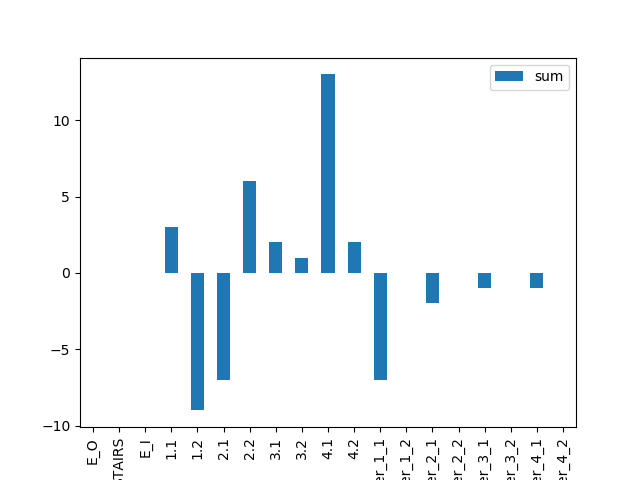

In [34]:
df_flux_sum = df_flux_sum.drop(index='time(s)')
df_flux_sum.plot.bar()

In [31]:
#working out the sum of flux on each region

sums =  []



for k in range(0, len(zone_names)):
    sums.append((df_net[zone_names[k]].sum()))



df_sums = pd.DataFrame(sums)
df_zones = pd.DataFrame(zone_names)

df_flux_sums = pd.concat([ df_zones, df_sums], axis=1)
df_flux_sums

,0,0
0,E_O,0
1,STAIRS,0
2,E_I,0
3,1.1,3
4,1.2,-9
5,2.1,-7
6,2.2,6
7,3.1,2
8,3.2,1
9,4.1,13


In [ ]:
# Plotting each flux for entered and left
rows = len(zone_names_array)
cols = len(zone_names_array[0])
fig, ax = plt.subplots(rows,cols, figsize = (30,20), sharey = True, sharex = True)
for i in range(rows):
    for j in range(cols):
        df_left.plot('time(s)', zone_names_array[i][j], ax = ax[i,j], linewidth = 0.5)
        df_entered.plot('time(s)', zone_names_array[i][j], ax = ax[i,j], linewidth = 0.5)
        ax[i,j].set_title(zone_names_array[i][j])
        ax[i,j].legend(['left', 'entered'])
        ax[i,j].grid('on')

<IPython.core.display.Javascript object>


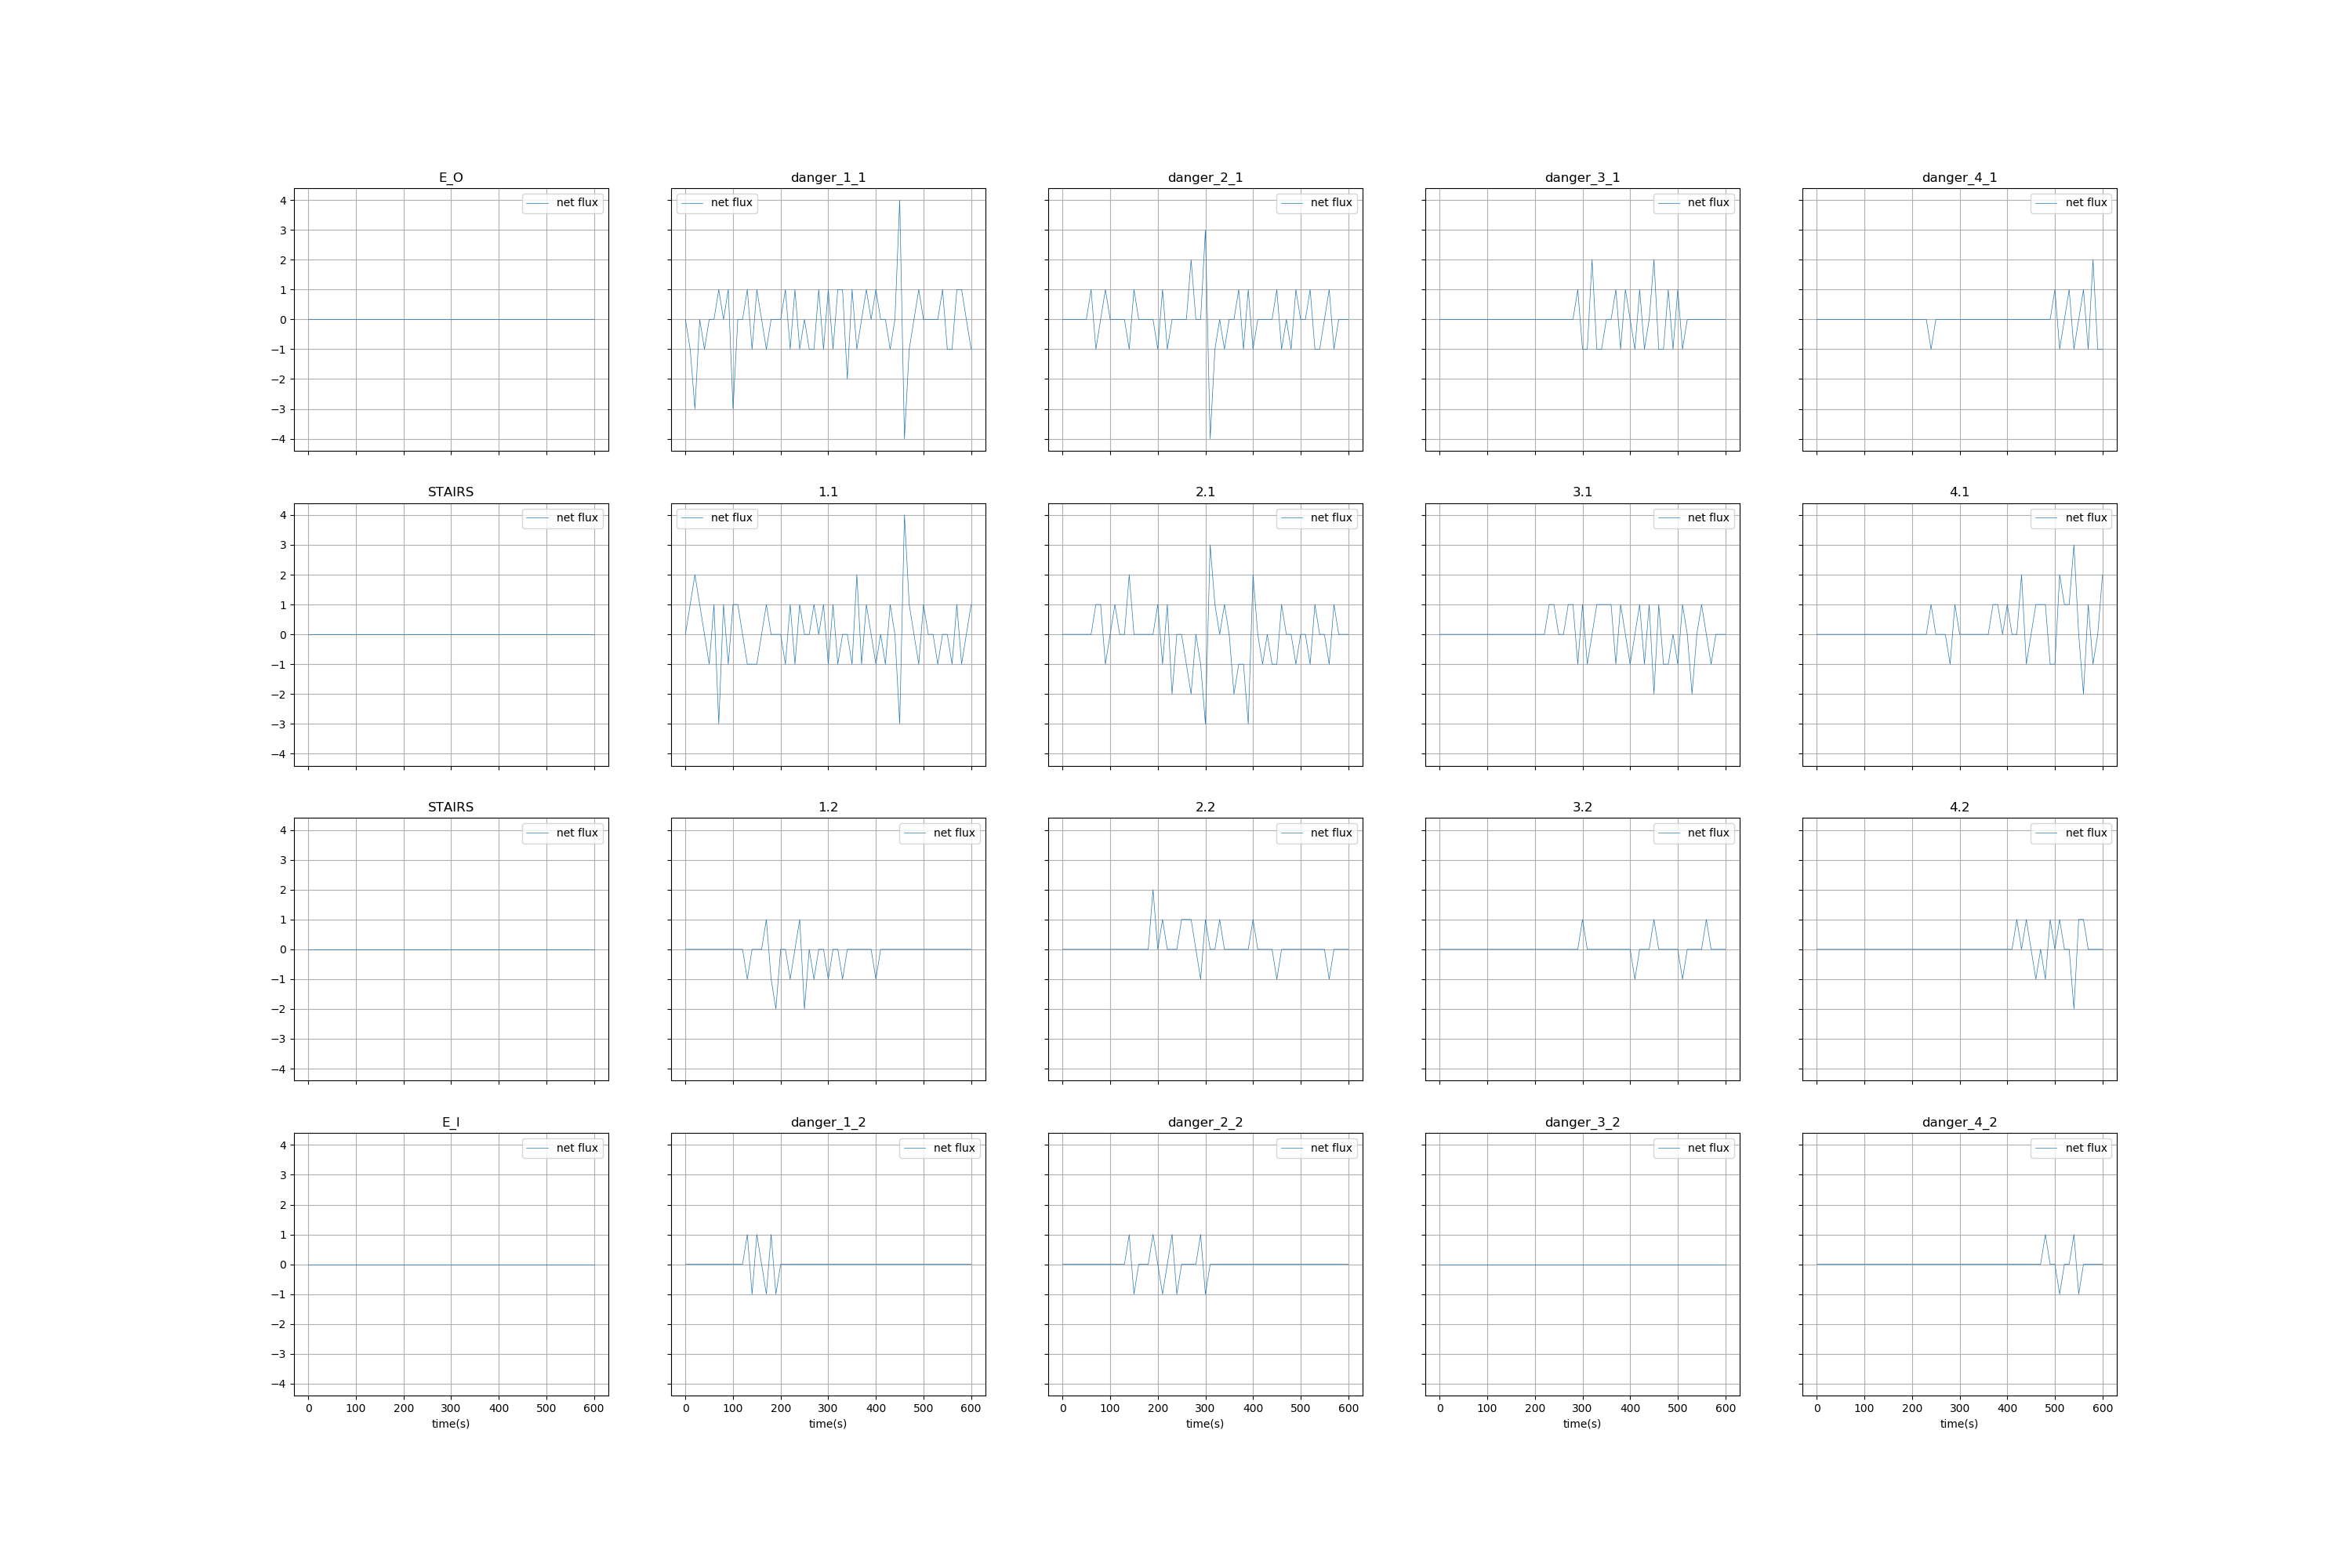

In [43]:
# Plotting net flux
rows = len(zone_names_array)
cols = len(zone_names_array[0])
fig, ax = plt.subplots(rows,cols, figsize = (30,20), sharey = True, sharex = True)
for i in range(rows):
    for j in range(cols):
        df_net.plot('time(s)', zone_names_array[i][j], ax = ax[i,j], linewidth = 0.5)
        ax[i,j].set_title(zone_names_array[i][j])
        ax[i,j].legend(['net flux'])
        ax[i,j].grid('on')

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/background_images/EHV.Perron2.1_multisensor.png
background fetched. Accessible as <this-object>.bg


<IPython.core.display.Javascript object>


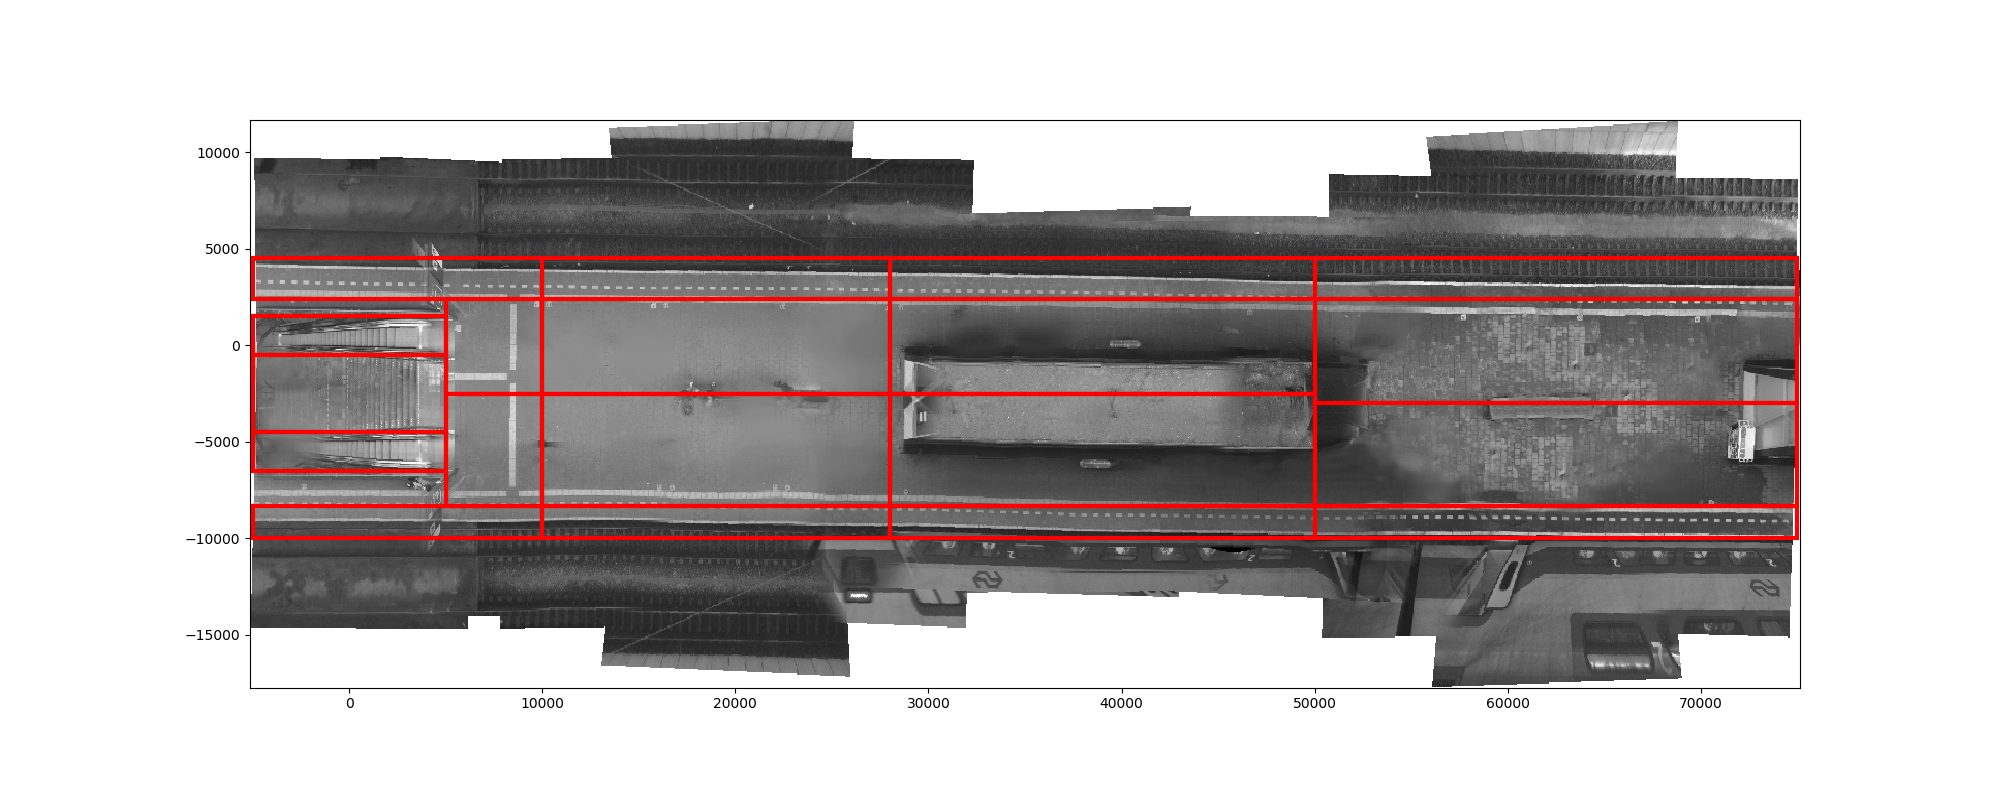

In [40]:
# Retrieve the background image
dh.fetch_background_image_from_path('ehv/background_images/EHV.Perron2.1_multisensor.png')
dh.bg

# Plot on top of the background image

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

xmin = -5134
ymin = -17731
xmax =  75135
ymax =  11645

# Plot of the background
ax.imshow(dh.bg, cmap = 'gray', extent=[xmin, xmax, ymin, ymax])

#Plot the boarding limits
for i in range(len(limits_array)):
    width = limits_array[i][1] - limits_array[i][0]
    height = limits_array[i][3] - limits_array[i][2]
    rect_limits = patches.Rectangle((limits_array[i][0], limits_array[i][2]), width, height, linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect_limits)
